In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import cPickle

import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import img_to_array

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Layer, LSTM, Input, TimeDistributed
from keras.optimizers import RMSprop
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from keras.datasets import cifar100

Using TensorFlow backend.


In [2]:
# utility functions
def my_confusion_matrix(prediction_classes, label_data):
    """ Purpose: generate n_class by n_class matrix
                 the matrix rows are predicted true indice,
                 the columns are actual true indices
        Input:   predictions_classes being matrix of each event's prediction class, i.e. [34, 45, 23, ...]
                 label_data being matrix of each event's label [[0 0 1 0 ..], [1 0 0 ..], ...]
    
        Output:  confusion_matrix """
    nsize = label_data.shape[1]
    result = np.zeros((nsize,nsize))
    nevents = label_data.shape[0]
    for irow in range(nevents):
        count = 0
        nrow = prediction_classes[irow]
        ncol = label_data[irow].tolist().index(1.0)
        result[nrow, ncol] += 1
    
    return result

In [3]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
  
#def tf_imgdata_generator(image, label, is_training, batch_size=128):
#    '''Generate digitized (x_train,y_train) dataset'''
    
def mapping_func(image, label):
    '''Preprocess raw image data into trainable input'''
    X = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
    Y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
    return X,Y
  
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )
        Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


In [4]:
# load dataset
batch_size = 64
num_classes = 100
epochs = 100
(x_train,y_train), (x_test, y_test) = cifar100.load_data()

In [5]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


(50000, 32, 32, 3)
(50000, 1)


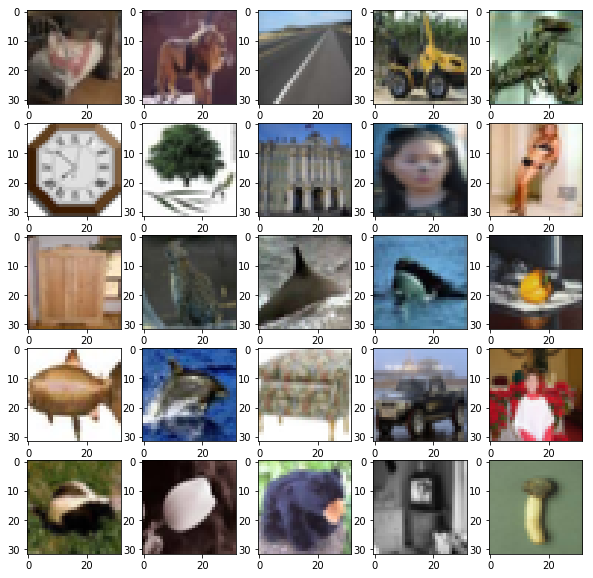

In [6]:
print(x_train.shape)
print(y_train.shape)
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for j in range(5):
    for i in range(5):
        k = np.random.choice(range(len(x_train)))
        axes[j][i].imshow(x_train[k:k+1][0], interpolation='nearest')

## The first CNN model, with filter size (3,3)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: {} loss: {}'.format(scores[1]*100,scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

Epoch 26/125
781/781 [==============================] - 1110s 1s/step - loss: 2.3674 - acc: 0.5050 - val_loss: 2.2564 - val_acc: 0.5371
Epoch 27/125
781/781 [==============================] - 1111s 1s/step - loss: 2.3746 - acc: 0.5039 - val_loss: 2.3311 - val_acc: 0.5281
Epoch 28/125
781/781 [==============================] - 1110s 1s/step - loss: 2.3560 - acc: 0.5104 - val_loss: 2.2277 - val_acc: 0.5482
Epoch 29/125
781/781 [==============================] - 1110s 1s/step - loss: 2.3445 - acc: 0.5152 - val_loss: 2.1977 - val_acc: 0.5545
Epoch 30/125
781/781 [==============================] - 1109s 1s/step - loss: 2.3326 - acc: 0.5153 - val_loss: 2.1468 - val_acc: 0.5604
Epoch 31/125
781/781 [==============================] - 1108s 1s/step - loss: 2.3238 - acc: 0.5205 - val_loss: 2.3091 - val_acc: 0.5408
Epoch 32/125
781/781 [==============================] - 1111s 1s/step - loss: 2.3173 - acc: 0.5237 - val_loss: 2.1883 - val_acc: 0.5574
Epoch 33/125
781/781 [==========================

In [44]:
# evaluating the model
#import seaborn as sns
#from sklearn.metrics import confusion_matrix
#import iterpools

#predictions = model.predict(x_train, batch_size=10, verbose=0)
#predictions_classes = model.predict_classes(x_train, batch_size=10, verbose=0)

#out_matr = my_confusion_matrix(predictions_classes, y_train)
#np.savetxt('confusion_matrix.csv', out_matr, delimiter=',')
#out = pd.read_csv('confusion_matrix.csv', header=None)
#out.head()
nsize = 100
colname = np.arange(nsize)
norm = np.zeros((nsize,nsize))
norm_matr = pd.DataFrame(norm, columns=colname)
for icol in range(nsize):
    norm_matr.iloc[:, icol] = out.iloc[:, icol] / np.sum(out.iloc[:, icol])

In [48]:
print(norm_matr)

       0      1      2      3      4      5      6      7      8      9   \
0   0.926  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1   0.000  0.868  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002   
2   0.000  0.000  0.622  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
3   0.000  0.000  0.002  0.578  0.004  0.000  0.002  0.000  0.000  0.000   
4   0.000  0.000  0.002  0.024  0.520  0.000  0.000  0.000  0.000  0.000   
5   0.000  0.000  0.000  0.000  0.000  0.948  0.000  0.000  0.000  0.006   
6   0.000  0.000  0.000  0.008  0.002  0.000  0.870  0.018  0.000  0.002   
7   0.000  0.002  0.000  0.006  0.002  0.000  0.014  0.820  0.000  0.000   
8   0.000  0.000  0.016  0.004  0.002  0.002  0.002  0.004  0.990  0.010   
9   0.000  0.000  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.846   
10  0.004  0.000  0.000  0.000  0.002  0.002  0.000  0.002  0.000  0.000   
11  0.000  0.000  0.062  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
12  0.000  0

## confusion matrix's heatmap

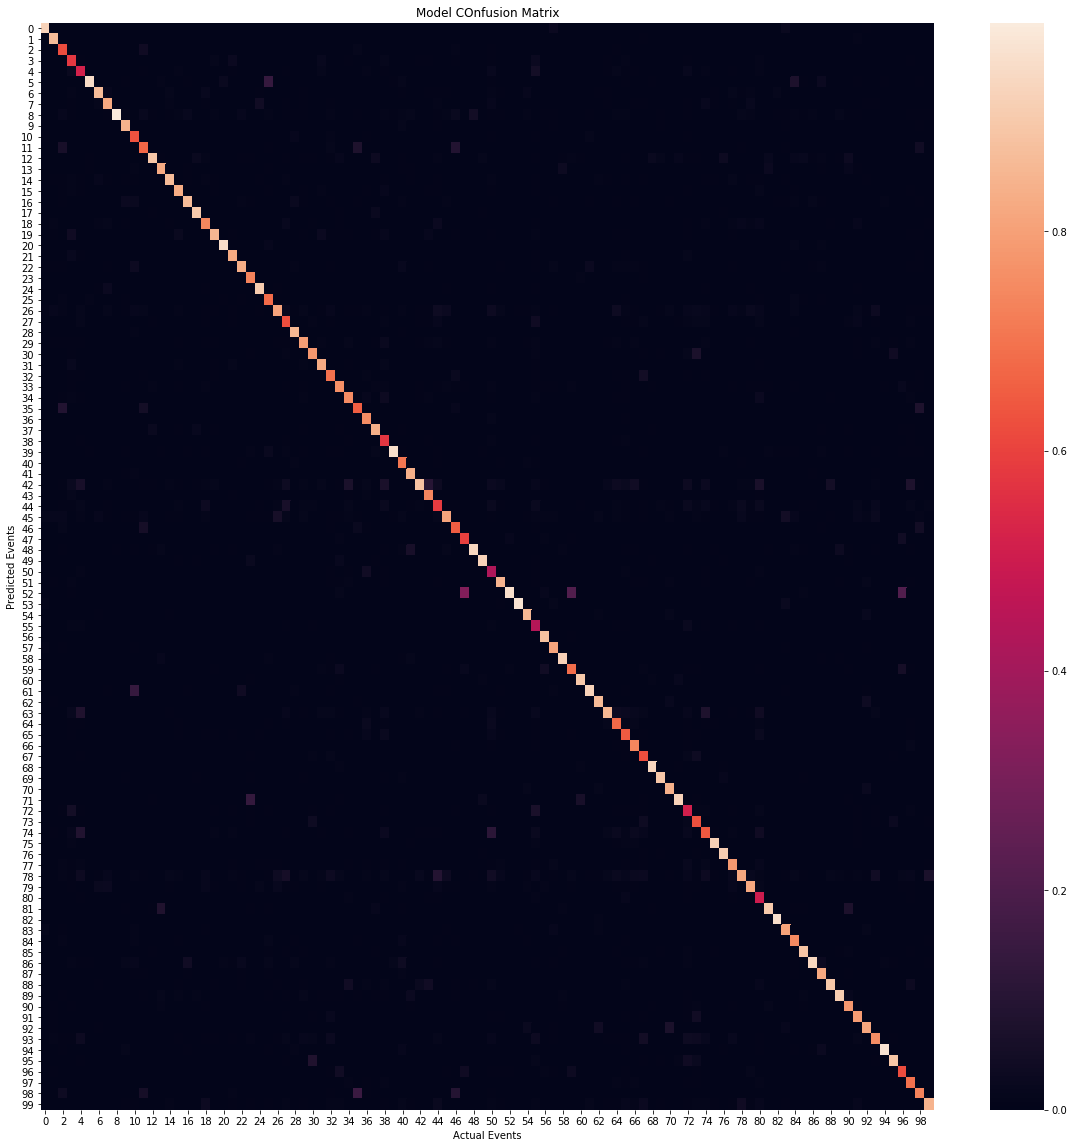

In [50]:
plt.figure(figsize=(20,20))
sns.heatmap(norm_matr)
plt.xlabel('Actual Events')
plt.ylabel('Predicted Events')
plt.title('Model Confusion Matrix')
plt.show()

<Figure size 720x2880 with 0 Axes>

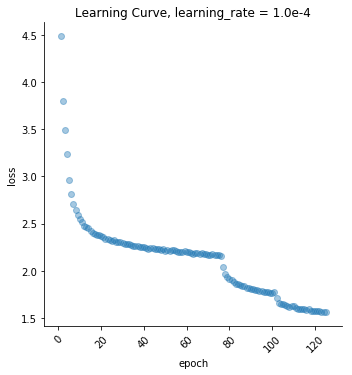

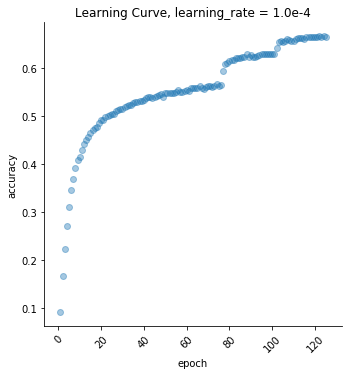

In [53]:
learning_curve = pd.read_csv('curve_loss_accuracy_run1.csv')
fig = plt.figure(figsize=(10,40))
#fig.add_subplot(121)
graph = sns.lmplot(x='epoch', y='loss', data=learning_curve, fit_reg=False, scatter_kws={'alpha':0.4})
plt.xticks(rotation=45)
graph.set_xlabels('epoch')
graph.set_ylabels('loss')
plt.title('Learning Curve, learning_rate = 1.0e-4')

#fig.add_subplot(122)
graph = sns.lmplot(x='epoch', y='accuracy', data=learning_curve, fit_reg=False, scatter_kws={'alpha':0.4})
plt.xticks(rotation=45)
graph.set_xlabels('epoch')
graph.set_ylabels('accuracy')
plt.title('Learning Curve, learning_rate = 1.0e-4')
plt.show()

## more will be found in a separate jupyter notebook